<a href="https://colab.research.google.com/github/elenagonzalezrebollo/Entregas-DeepLearning/blob/main/LAB3IAGenerativa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB3 IA Generativa - Javier Arteaga y Elena Gonzalez


#**Ejercicio 1:** Entrenar un Variational Autoencoder del dataset datasets.fashion_mnist. Además usar la red decoder para convertir vectores espaciales latentes arbitrarios en imágenes.

## Generando imágenes con autocodificadores variacionales (variational autoencoders)

### Implementando un VAE con Keras

El VAE consta de tres partes principales:

**Encoder (Codificador)**: Esta parte de la red toma una imagen de entrada y la convierte en dos vectores, z_mean y z_log_var, que representan la media y la varianza de una distribución en el espacio latente. Aquí, se utiliza un convnet simple para mapear la imagen de entrada a estos parámetros de distribución.

**Sampling (Muestreo)**: Una vez que se han calculado z_mean y z_log_var, se utiliza un proceso de muestreo para tomar un punto aleatorio del espacio latente. Este punto aleatorio se utilizará más adelante en el proceso de decodificación.

**Decoder (Decodificador)**: El punto muestreado del espacio latente se alimenta a esta parte de la red, que lo decodifica de vuelta en una imagen reconstruida. El decodificador también es un convnet que toma el punto del espacio latente como entrada y produce una imagen reconstruida como salida.

**Red encoder VAE**

Se define la parte del codificador de un Variational Autoencoder (VAE) en TensorFlow.

Convierte una imagen de entrada en dos vectores, z_mean y z_log_var, que representan la media y la varianza en un espacio latente de 2 dimensiones.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

# Dimensionalidad del espacio latente: un plano 2D
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
# La imagen de entrada termina siendo codificada
# en estos dos parámetros: z_mean y z_log_var
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

Se hace un resumen de esto, donde se muestra la forma de las copas y el número de parámetros que estos tienen

In [3]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 32)           320       ['input_2[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d_2[0][0]']            
                                                                                                  
 flatten_1 (Flatten)         (None, 3136)                 0         ['conv2d_3[0][0]']            
                                                                                            

El siguiente código es para **generar un punto espacial latente ``z``** usando ``z_mean`` y ``z_log_var``, los parámetros de la distribución estadística que se supone que produjeron ``input_img``:

**Capa de muestreo-espacio-latente (Latent-space-sampling)**

In [4]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        # Dibuja un lote de vectores normales aleatorios.
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        # Aplicar la fórmula de muestreo VAE
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

**Se implenta el decodificador**

**Red de decodificadores VAE, asignando puntos de espacio latente a imágenes**

Tras probar varias configuraciones hemos llegado a la que se muestra actualmente.

In [5]:
# Entrada a través de la cual alimentaremos con z
latent_inputs = keras.Input(shape=(latent_dim,))
# Producimos la misma cantidad de coeficientes que
# teníamos al nivel de la capa Flatten en el codificador.
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# Revertimos la capa Flatten del codificador.
x = layers.Reshape((7, 7, 64))(x)
# Revertimos las capas Conv2D del codificador.
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# La salida termina con la forma (28, 28, 1)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

Se hace un resumen de este decodificador

In [6]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 1)         289 

Creamos el **propio modelo VAE**. **Este es nuestro primer ejemplo de un modelo que no realiza aprendizaje supervisado** (un autoencoder es un ejemplo de **aprendizaje autosupervisado**, porque **utiliza sus entradas como objetivos**). Cada vez que se sale del aprendizaje supervisado clásico, es **común crear una subclase de la clase ``Model`` e implementar un ``train_ step()`` personalizado para especificar la nueva lógica de entrenamiento**.

**Modelo VAE con `train_step()` personalizado**

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        # Usamos estas métricas para realizar un seguimiento
        # de los promedios de pérdida en cada época.
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    # Listamos las métricas en la propiedad metrics para permitir
    # que el modelo las restablezca después de cada época (o entre
    # varias llamadas a fit()/evaluate())
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            # Sumamos la pérdida de reconstrucción sobre las
            # dimensiones espaciales (ejes 1 y 2) y tomamos
            # su media sobre la dimensión del lote.
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # Agreguamos el término de regularización
            # (divergencia de Kullback-Leibler).
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Ahora **instanciamos y entrenar el modelo en dígitos MNIST**. Debido a que la **pérdida se soluciona en la capa personalizada**, **no especificamos una pérdida externa** en el momento de la compilación (``loss=None``), lo que a su vez significa que **no pasaremos los datos target durante el entrenamiento** (como podemos ver, solo pasamos ``x_train`` al modelo en ``fit()``).

**Entrenando la VAE**

Se entrena nuestro VAE con un optimizador Adam y el cual se entrena en los datos de entrada MNIST durante 30 épocas sin especificar una función de pérdida ni objetivos, ya que estos están incorporados en el método train_step() del modelo, que ya fueron definidos.

In [8]:
import numpy as np
import keras
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
# Entrenamos en todos los dígitos MNIST, por lo que
# concatenamos las muestras de entrenamiento y prueba.
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
# Notemos que no pasamos un argumento de pérdida a compile(),
# ya que la pérdida ya es parte de train_step()
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
# Notemos que no pasamos objetivos (targets) en fit(),
# ya que train_step() no espera ninguno
vae.fit(mnist_digits, epochs=30, batch_size=128)

4422102/4422102 [==============================] - 0s 0us/step
Epoch 1/30


547/547 [==============================] - 36s 53ms/step - total_loss: 316.6046 - reconstruction_loss: 312.0004 - kl_loss: 4.6042
Epoch 2/30
547/547 [==============================] - 29s 52ms/step - total_loss: 271.2357 - reconstruction_loss: 267.2855 - kl_loss: 3.9504
Epoch 3/30
547/547 [==============================] - 29s 53ms/step - total_loss: 267.9323 - reconstruction_loss: 264.2132 - kl_loss: 3.7193
Epoch 4/30
547/547 [==============================] - 27s 50ms/step - total_loss: 266.2112 - reconstruction_loss: 262.5565 - kl_loss: 3.6545
Epoch 5/30
547/547 [==============================] - 27s 49ms/step - total_loss: 264.8747 - reconstruction_loss: 261.2559 - kl_loss: 3.6190
Epoch 6/30
547/547 [==============================] - 28s 51ms/step - total_loss: 264.0915 - reconstruction_loss: 260.5024 - kl_loss: 3.5892
Epoch 7/30
547/547 [==============================] - 27s 49ms/step - total_loss: 263.2761 - reconstruction_loss: 259.7045 - kl_loss: 3.5717
Epoch 8/30
547/547 [====

Observamos que la pérdida total, la pérdida de reconstrucción y la pérdida KL disminuyen gradualmente a medida que avanzan las épocas. Esto sugiere que el modelo está aprendiendo a reconstruir con precisión las imágenes de entrada y a distribuir los puntos en el espacio latente de manera efectiva.

La pérdida total es una combinación de la pérdida de reconstrucción (que mide la fidelidad de la reconstrucción de las imágenes) y la pérdida KL (que mide la divergencia entre la distribución en el espacio latente y una distribución de referencia, generalmente una distribución normal estándar).

En resumen, el VAE está aprendiendo correctamente

**Muestreo de una cuadrícula de imágenes del espacio latente 2D**


Una vez que se entrena el modelo, podemos **usar la red ``decoder``** para **convertir vectores espaciales latentes arbitrarios en imágenes**.

1/1 [==============================] - 0s 16ms/step


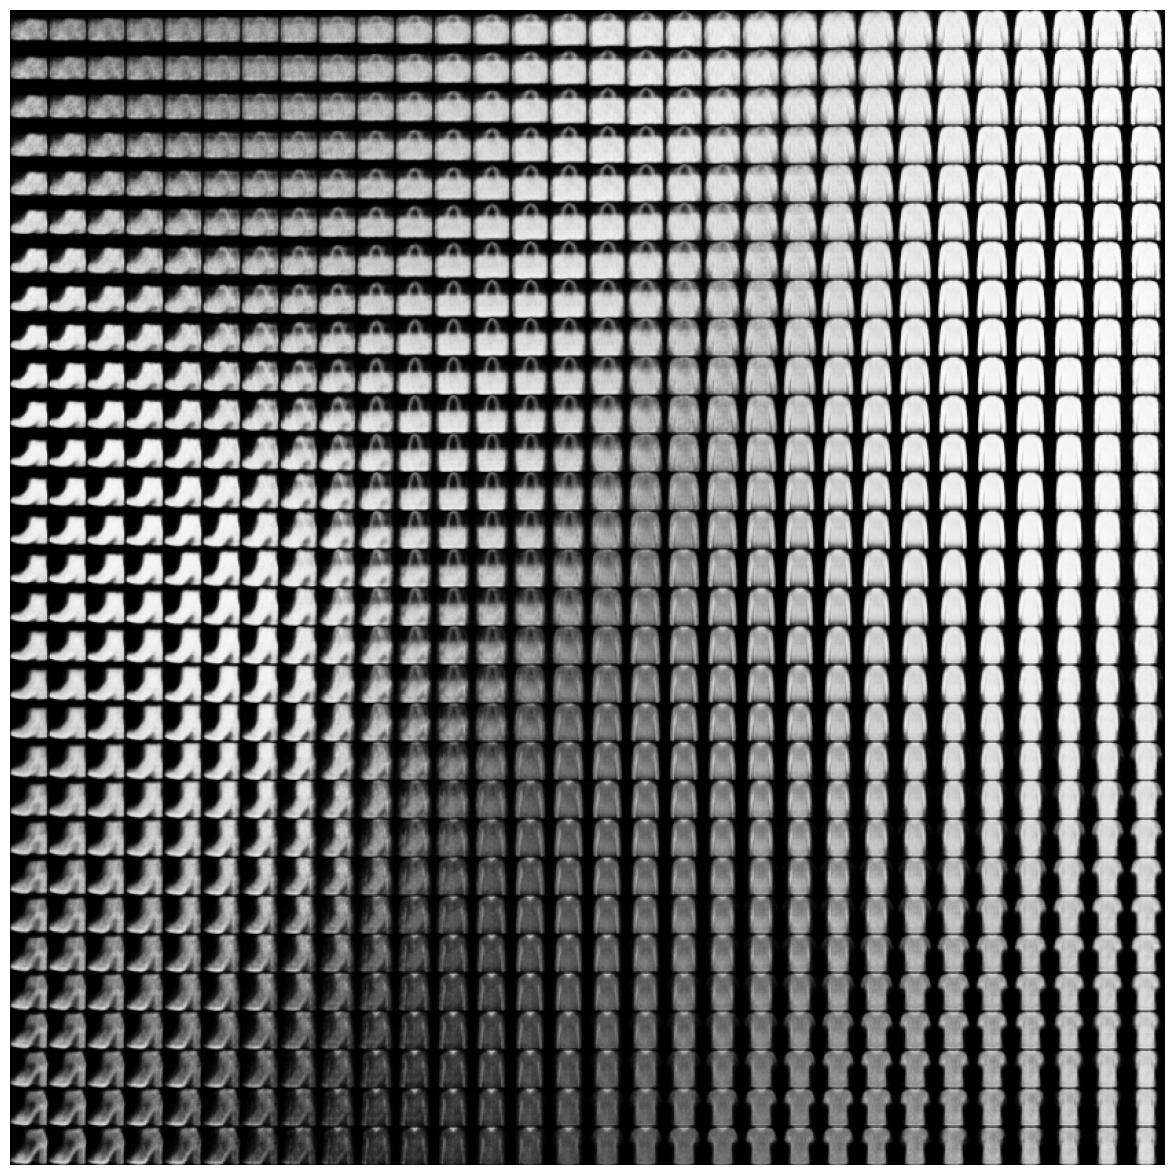

In [9]:
import matplotlib.pyplot as plt

# Mostraremos una cuadrícula de
# 30 × 30 dígitos (900 dígitos en total)
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Muestree de puntos linealmente en una cuadrícula 2D.
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # Para cada ubicación, muestreamos un
        # dígito y lo agregamos a nuestra figura
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

Se puede apreciar como las imágines salen con una calidad aceptable y a simple vista se pueden distinguir que prenda está reprensentada en cada imágen.

Esto significa que se ha realizado correctamente la decodificación del espacio latente

#**Ejercicio 2:** Dada la siguiente base de datos de zapatos (https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip). Entrenar una GAN para generar imágenes de zapatos nuevas.


## Redes Antagónicas Generativas (Generative Adversarial Networks - GANs)

**Cargar los datos**

El primer paso que debemos hacer es descargamos un conjunto de datos de imágenes (https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip), el cual descomprimimos y las cargamos en memoria para su posterior procesamiento.












In [ ]:
# Creamos el directorio de trabajo
!mkdir ut_zap50k

# Descargamos el archivo ZIP
!wget -O ut_zap50k/ut-zap50k-images-square.zip https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip

# Descomprimimos los datos
!unzip -qq ut_zap50k/ut-zap50k-images-square.zip -d ut_zap50k

# Ahora puedes cargar las imágenes con keras de la manera que necesites.
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    'ut_zap50k',
    label_mode=None,
    image_size=(136, 136),
    batch_size=32,
    smart_resize=True)


--2024-05-04 09:29:02--  https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip
Resolving vision.cs.utexas.edu (vision.cs.utexas.edu)... 128.83.130.185
Connecting to vision.cs.utexas.edu (vision.cs.utexas.edu)|128.83.130.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144233542 (138M) [application/zip]
Saving to: ‘ut_zap50k/ut-zap50k-images-square.zip’

ut_zap50k/ut-zap50k 100%[===================>] 137.55M  60.2MB/s    in 2.3s    

2024-05-04 09:29:04 (60.2 MB/s) - ‘ut_zap50k/ut-zap50k-images-square.zip’ saved [144233542/144233542]

Found 50066 files belonging to 1 classes.


Se rescalan las imágenes

In [ ]:
dataset = dataset.map(lambda x: x / 255.)

Se muestra la primera imagen para ver que tipo de imágenes tenemos tenemos en esta dataset

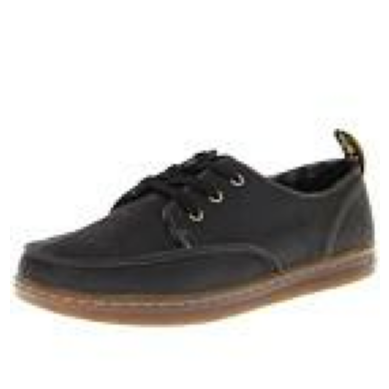

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

### El discriminator

**Modelo ``discriminator``**: **toma** como entrada una **imagen candidata** (real o sintética) **y la clasifica** en una de dos clases: **"generated image"** o **"real image that comes from the training set"**.

Uno de los muchos **problemas** que surgen comúnmente **con las GAN** es que el **generador se atasca con imágenes generadas que parecen ruido**. Una posible solución es **usar dropout en el discriminador**, eso es lo que haremos aquí.

**La red discriminadora (discriminator) GAN**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(136, 136, 3)),  # La forma de entrada para imágenes 136x136 con 3 canales de color
        layers.Conv2D(136, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(272, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(272, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),  # Dropout para ayudar a evitar el sobreajuste
        layers.Dense(1, activation="sigmoid"),  # Salida con activación sigmoid para clasificación binaria
    ],
    name="discriminator",
)


Aqui se muestan la forma de las redes convolucionales y el total de parámetros de esta, por ejemplo la primera tiene 6664 paramentros y una forma de  (None, 68, 68, 136)

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 136)       6664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 68, 68, 136)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 272)       592144    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 34, 34, 272)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 272)       1184016   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 17, 17, 272)       0         
                                                                 
 flatten (Flatten)           (None, 78608)           

### El generator

Modelo generator: Se convierte un vector (desde el espacio latente; durante el entrenamiento se muestreará al azar) en una imagen candidata.

**La Red Generadora GAN**

Se define un generador de imágenes utilizando una red neuronal convolucional (CNN). Toma un vector de números aleatorios como entrada y genera una imagen de 136x136 píxeles con tres canales (RGB).

El generador utiliza capas de convolución transpuesta para aumentar progresivamente la resolución de la imagen.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 272  # Dimensión del espacio latente

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # Capa densa para generar suficientes coeficientes para un feature map inicial
        layers.Dense(17*17*272),  # Ajustamos para que el tamaño inicial sea más grande
        # Revertimos la capa Flatten
        layers.Reshape((17, 17, 272)),
        # Primera capa Conv2DTranspose para comenzar el upsampling
        layers.Conv2DTranspose(272, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        # Segunda capa Conv2DTranspose
        layers.Conv2DTranspose(136, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        # Tercera capa Conv2DTranspose para alcanzar el tamaño objetivo
        layers.Conv2DTranspose(136, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        # Capa de salida Conv2D para generar la imagen final de 136x136 con 3 canales
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)


In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 78608)             21459984  
                                                                 
 reshape (Reshape)           (None, 17, 17, 272)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 34, 34, 272)       1184016   
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 34, 34, 272)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 68, 68, 136)       592008    
 Transpose)                                                      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 68, 68, 136)       0 

### La Red Antagónica (Adversarial)

Finalmente, **configuraremos el GAN**, que **encadena el generador y el discriminador**. Cuando **se entrena**, **este modelo moverá el generador en una dirección que mejora su capacidad para engañar al discriminador**. El **modelo convierte los puntos de espacio latente en una decisión de clasificación**, "fake" o "real", y **está destinado a ser entrenado con etiquetas** que siempre son **"estas son imágenes reales"**. Entonces, **el ``gan`` de entrenamiento actualizará los pesos del ``generator`` de una manera que hace que el ``discriminator`` sea más probable que prediga "real" cuando mira imágenes falsas**.

**Ciclo de entranamiento esquemático**. Para cada época, hacemos lo siguiente:
1. **Dibujar puntos aleatorios en el espacio latente** (**ruido aleatorio**).
2. **Generamos imágenes con ``generator`` usando este ruido aleatorio**.
3. **Mezclamos** las **imágenes generadas** **con** las **reales**.
4. **Entrenamos al ``discriminator``** utilizando estas **imágenes mezcladas**, **con los objetivos correspondientes**: ya sea "**real**" (para las imágenes reales) o "**fake**" (para las **imágenes generadas**).
5. **Dibujamos nuevos puntos aleatorios en el espacio latente**.
6. **Entrenamos el ´´generator´´ usando estos vectores aleatorios**, con **objetivos que dicen "estas son imágenes reales"**. **Esto actualiza los pesos del generador para moverlos para que el discriminador prediga "estas son imágenes reales" para las imágenes generadas: esto entrena al generador para engañar al discriminador**.

* Lo implementamos usando una **subclase de ``Model`` con un ``train_step()`` personalizado** (como hicimos con VAE)
* Usaremos **dos optimizadores** (uno para el **generador** y otro para el **discriminador**), por lo que también **sobreescribiremos ``compile()`` para permitir el paso de los dos optimizadores**.

**El `Model` GAN**

In [ ]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        # Configura métricas para rastrear las dos
        # pérdidas en cada época de entrenamiento
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Muestrea puntos aleatorios en el espacio latente
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # Los decodifica a imágenes falsas
        generated_images = self.generator(random_latent_vectors)
        # Los combina con imágenes reales
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Ensambla etiquetas, discriminando imágenes reales de falsas
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        # Agrega ruido aleatorio a las etiquetas: ¡un truco importante!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Entrenamos al discriminador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            # Muestrea puntos aleatorios en el espacio latente
            shape=(batch_size, self.latent_dim))

        # Ensambla etiquetas de imágenes reales
        misleading_labels = tf.zeros((batch_size, 1))

        # Entrena al generador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

Antes de iniciar el entrenamiento, configuramos una "callback" para supervisar nuestros resultados. Esta "callback" utilizará el generador para crear y guardar un conjunto de imágenes falsas al final de cada época.

Una callback que muestra imágenes generadas durante el entrenamiento

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

Finalmente, podemos comenzar a entrenar

**Compilando y entrenando la GAN**

Limito el entrenamiento de mi red neuronal GAN a solo 10 épocas debido al tiempo de ejecución prolongado

In [ ]:
epochs = 10

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/10
1565/1565 [==============================] - 884s 551ms/step - d_loss: 0.5249 - g_loss: 1.9633
Epoch 2/10
1565/1565 [==============================] - 854s 546ms/step - d_loss: 0.4797 - g_loss: 1.7129
Epoch 3/10
1565/1565 [==============================] - 851s 544ms/step - d_loss: 0.4721 - g_loss: 1.9234
Epoch 4/10
1565/1565 [==============================] - 850s 543ms/step - d_loss: 0.4792 - g_loss: 1.9347
Epoch 5/10
1565/1565 [==============================] - 850s 543ms/step - d_loss: 0.4460 - g_loss: 2.1287
Epoch 6/10
1565/1565 [==============================] - 851s 543ms/step - d_loss: 0.5435 - g_loss: 1.7108
Epoch 7/10
1565/1565 [==============================] - 853s 545ms/step - d_loss: 0.5227 - g_loss: 1.7007
Epoch 8/10
1565/1565 [==============================] - 853s 545ms/step - d_loss: 0.4927 - g_loss: 1.7935
Epoch 9/10
1565/1565 [==============================] - 854s 546ms/step - d_loss: 0.5063 - g_loss: 1.7083
Epoch 10/10
1565/1565 [=======================


Después de 10 épocas de entrenamiento, observamos que tanto la pérdida del discriminador (d_loss) como la pérdida del generador (g_loss) fluctúan en cada época. La pérdida del discriminador parece estar alrededor de 0.47, mientras que la pérdida del generador varía entre alrededor de 1.7 y 2.1.

Esto sugiere que el modelo está aprendiendo, pero puede que aún no haya convergido completamente. Sería útil observar las imágenes generadas para evaluar la calidad visual de las mismas y determinar si el modelo necesita más entrenamiento o ajustes en sus hiperparámetros.

Durante el proceso de entrenamiento, es probable que notemos un aumento significativo en la pérdida adversarial mientras que la pérdida discriminativa tiende a disminuir, lo que sugiere que el discriminador está dominando sobre el generador. En este caso, podemos intentar contrarrestar este desequilibrio reduciendo la velocidad de aprendizaje del discriminador y aumentando la probabilidad de dropout del discriminador.

A continuación mostramos algunas imagenes generadas

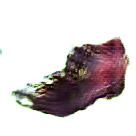
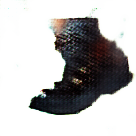
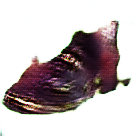
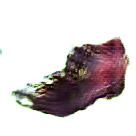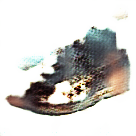

Las imágenes generadas no alcanzan una calidad óptima debido al entrenamiento limitado a solo 10 épocas.

Una de las opciones sería reducir el numéro de épocas, aunque es cierto que tal y como está ahora el modelo se puede apreciar en cada imagen la prenda de ropa que es